In [362]:
from astropy.table import Table
import astropy.units as u
import naima
import numpy as np
import matplotlib.pyplot as plt

In [363]:
sed_day1 = Table.read('../data/RSOph/RSOph_day1_sed.ecsv',format='ascii.ecsv')
sed_day2 = Table.read('../data/RSOph/RSOph_day2_sed.ecsv',format='ascii.ecsv')
sed_day4 = Table.read('../data/RSOph/RSOph_day4_sed.ecsv',format='ascii.ecsv')

daily_data = [sed_day1, sed_day2, sed_day4]

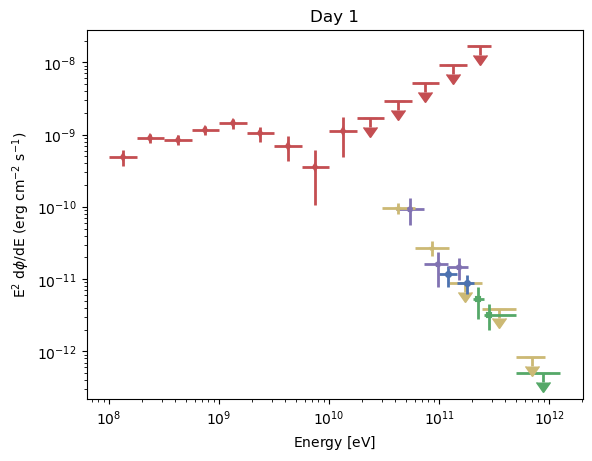

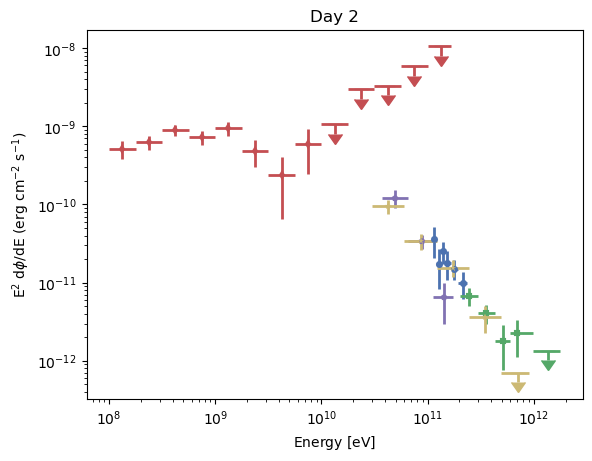

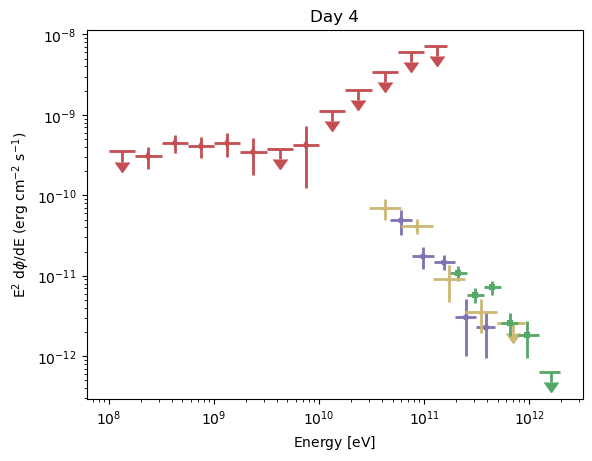

In [372]:
for day,data in zip([1,2,4],daily_data):
    naima.plot_data(data, e_unit=u.eV, ylabel=f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
    plt.title(f"Day {day}")

# Hadronic model 

In [326]:
import astropy.units as u
import numpy as np
from astropy.io import ascii
from astropy.table import vstack
import naima
from naima.models import ExponentialCutoffPowerLaw, InverseCompton

def PionDecay(pars, data):
    """
    Define particle distribution model, radiative model, and return model flux
    at data energy values
    """

    ECPL = ExponentialCutoffPowerLaw(
        10 ** pars[0] / u.eV, 130 * u.GeV, pars[1], 10 ** pars[2] * u.GeV
    )
    PP = naima.models.PionDecay(ECPL, nh=6.0e8*(day_value/3)**(-3) * u.cm ** -3)

    return PP.flux(data, distance=2.45 * u.kpc)


def lnprior(pars):
    # Limit amplitude to positive domain
    logprob = naima.uniform_prior(pars[0], 0, np.inf)
               
    return logprob


In [327]:
p0 = np.array((31, 2.5, np.log10(200)))
## Set initial parameters and labels
labels = ["log10(norm)", "index", "log10(cutoff)"]
day_array=[1,2,4]

In [ ]:
for yy,iday in enumerate(day_array):
    
    p0 = np.array((31, 2.5, np.log10(200)))
    day_value=iday
    
    print("day",day_value)
    
    # Run sampler    
    sampler, pos = naima.run_sampler(
        data_table=daily_data[yy],
        p0=p0,
        labels=labels,
        model=PionDecay,
        prior=lnprior,
        nwalkers=50,
        nburn=10,
        nrun=50,
    #     threads=4,
        prefit=True,
        interactive=False,
    )
    ## Save run results
    out_root = "RSOph_results/hadronic_model/fit_naima_results_all_day{}".format(day_array[yy])
    naima.save_run(out_root + ".hdf5", sampler)

    ## Save diagnostic plots and results table
    naima.save_diagnostic_plots(out_root, sampler, sed=True)
    naima.save_results_table(out_root, sampler) 
    print( )
    print( )

day 1
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [30.9730667  2.5        2.30103  ] [naima.core]
INFO:    Initial lnprob(p0): -368.082 [naima.core]


In [ ]:
# 5 min com a molt

In [376]:
tabs=[]
for day in [1,2,4]:
    tab=Table.read(f"RSOph_results/hadronic_model/fit_naima_results_all_day{day}_results.ecsv")
    tabs.append(tab) 


In [377]:
tabs[0]

label,median,unc_lo,unc_hi
str13,float64,float64,float64
log10(norm),30.51943341934735,0.22888151509932797,0.18143691429081343
norm,3.306994145328654e+30,1.354670095273355e+30,1.7149386057824478e+30
index,2.513877073326861,0.15238368576881856,0.14318521536709516
log10(cutoff),2.4317680880293278,0.14506443669536662,0.21280748820265982
cutoff,270.25148479510835,76.74137857055575,170.8881942813498
blob1,nan,nan,nan


In [378]:
# file=f"RSOph_results/fit_naima_results_all_day{day}.hdf5"
# run=naima.read_run(file, modelfn=None)

In [379]:
from gammapy.modeling.models import (
    Models,
    SkyModel,
    NaimaSpectralModel
)


particle_distribution_day1 = naima.models.ExponentialCutoffPowerLaw(tabs[0]["median"][1]*u.Unit('1/eV'), 
                                                               130.0 * u.GeV, 
                                                               tabs[0]["median"][2], 
                                                               tabs[0]["median"][4]*u.GeV)
radiative_model_day1 = naima.models.PionDecay(particle_distribution_day1, nh=6.0e8*(1/3)**(-3) * u.cm ** -3)
spec_model_day1 = NaimaSpectralModel(radiative_model_day1, distance=2.45 * u.kpc)

particle_distribution_day2 = naima.models.ExponentialCutoffPowerLaw(tabs[1]["median"][1]*u.Unit('1/eV'), 
                                                               130.0 * u.GeV, 
                                                               tabs[1]["median"][2], 
                                                               tabs[1]["median"][4]*u.GeV)
radiative_model_day2 = naima.models.PionDecay(particle_distribution_day2, nh=6.0e8*(2/3)**(-3) * u.cm ** -3)
spec_model_day2 = NaimaSpectralModel(radiative_model_day2, distance=2.45 * u.kpc)


particle_distribution_day4 = naima.models.ExponentialCutoffPowerLaw(tabs[2]["median"][1]*u.Unit('1/eV'), 
                                                               130.0 * u.GeV, 
                                                               tabs[2]["median"][2], 
                                                               tabs[2]["median"][4]*u.GeV)
radiative_model_day4 = naima.models.PionDecay(particle_distribution_day4, nh=6.0e8*(4/3)**(-3) * u.cm ** -3)
spec_model_day4 = NaimaSpectralModel(radiative_model_day4, distance=2.45 * u.kpc)



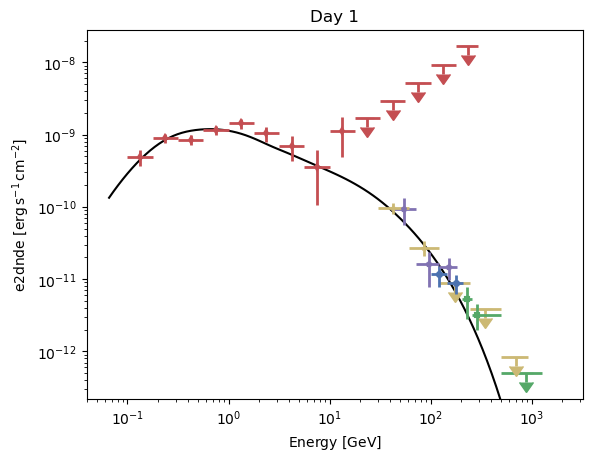

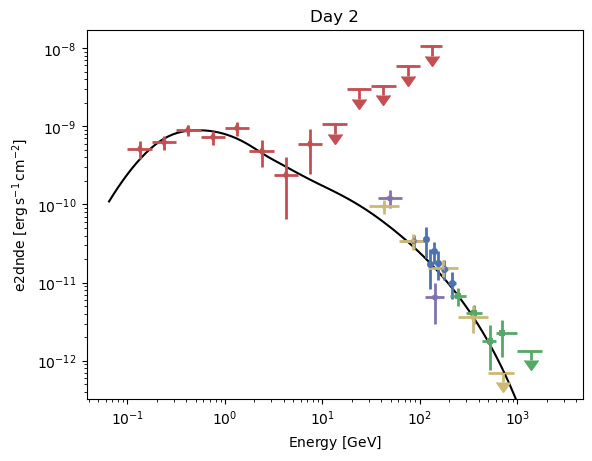

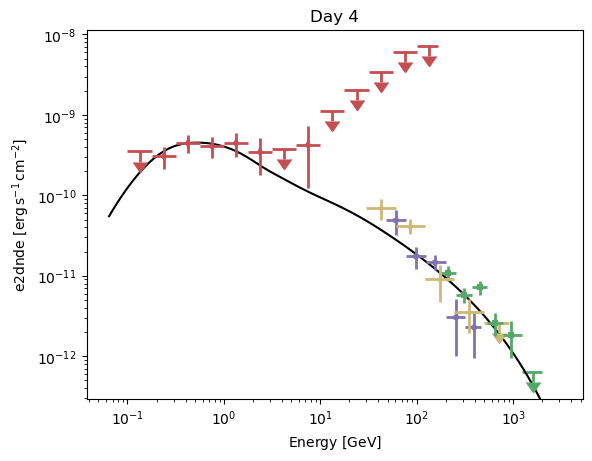

In [380]:
for day,data,spec_model in zip([1,2,4],daily_data,[spec_model_day1,spec_model_day2,spec_model_day4]):

    fig=naima.plot_data(data, e_unit=u.GeV)
    ax = fig.axes[0]
    ax.set_title(f"Day {day}")

    ax.xaxis.units = u.GeV
    ax.yaxis.units = u.Unit("erg s-1 cm-2")
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    spec_model.plot(sed_type="e2dnde",energy_bounds=[xmin*u.GeV,xmax*u.GeV],color="k",
                        label=r"Best-fit ($pp\rightarrow \pi_0 \rightarrow \gamma \gamma$)")
    ax.set_ylim((ymin, ymax))



[76.74137857055575, 170.8881942813498]

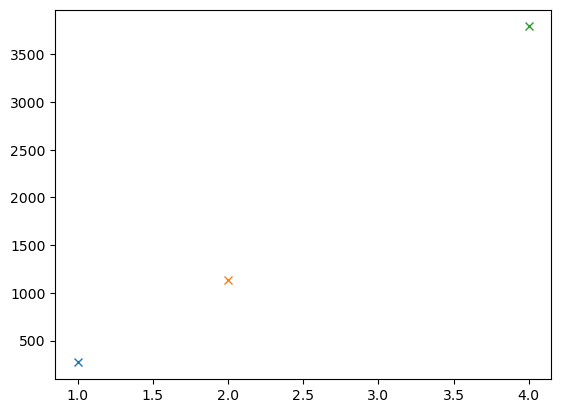

In [394]:
for day,tab in zip([1,2,4],tabs):
    plt.errorbar(day,tab["median"][-2],marker="x")

# Leptonic model

In [288]:
import astropy.units as u
import numpy as np
from astropy.io import ascii
from astropy.table import vstack
import naima
from naima.models import ExponentialCutoffPowerLaw, InverseCompton


def ICmodel(pars, data):
    amplitude = 10**pars[0] / u.eV
    alpha = pars[1]
    e_cutoff = (10 ** pars[2]) * u.GeV

    ECPL = ExponentialCutoffPowerLaw(amplitude, 130 * u.GeV, alpha, e_cutoff)
    IC = InverseCompton(
        ECPL,
        seed_photon_fields=[
            "CMB",
            ["photosphere", 
             Temp_value*u.K, 
             0.14*((Temp_value/8460)**4/(day_value/3)**2)*u.Unit("erg cm-3")]
        ],
    )

    return IC.flux(data, distance=2.45 * u.kpc)


def lnprior(pars):
    # Limit amplitude to positive domain
    logprob = naima.uniform_prior(pars[0], 0, np.inf)
               
    return logprob



In [290]:
Temp_value_array=[10780,9500,7680]
p0 = np.array((31, 2.5, np.log10(200)))
## Set initial parameters and labels
labels = ["log10(norm)", "index", "log10(cutoff)"]
day_array=[1,2,4]

In [292]:
for yy,iday in enumerate(day_array):
    
    p0 = np.array((31, 2.5, np.log10(200)))
    day_value=iday
    Temp_value=Temp_value_array[yy]    

    print("day",day_value)
    
    # Run sampler    
    sampler, pos = naima.run_sampler(
        data_table=daily_data[yy],
        p0=p0,
        labels=labels,
        model=ICmodel,
        prior=lnprior,
        nwalkers=10,
        nburn=10,
        nrun=50,
    #     threads=4,
        prefit=True,
        interactive=False,
    )
    ## Save run results
    out_root = "RSOph_results/leptonic_model/fit_naima_results_all_day{}".format(day_array[yy])
    naima.save_run(out_root + ".hdf5", sampler)

    ## Save diagnostic plots and results table
    naima.save_diagnostic_plots(out_root, sampler, sed=True)
    naima.save_results_table(out_root, sampler) 
    print( )
    print( )

day 1
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [28.34763285  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -16201.869 [naima.core]
INFO:    New ML parameters : [28.13788134  2.46651094  1.68094358] [naima.core]
INFO:    Maximum lnprob(p0): -17.518 [naima.core]
Burning in the 10 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.2            2.47            1.68      
  Last ensemble std    :      0.147           0.018          0.00489    
  Last ensemble lnprob :  avg: -34.258, max: -17.883

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.1            2.47            1.68      
  Last ensemble std    :      0.123          0.0151          0.00489    
  Last e

/Users/aaguasca/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/leptonic_model/fit_naima_results_all_day1_results.ecsv [naima.analysis]


day 2
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [29.01759026  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -8868.634 [naima.core]
INFO:    New ML parameters : [27.78571875  3.16241984  2.60010048] [naima.core]
INFO:    Maximum lnprob(p0): -17.406 [naima.core]
Burning in the 10 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.8            3.16            2.62      
  Last ensemble std    :      0.105          0.00645         0.0139     
  Last ensemble lnprob :  avg: -25.005, max: -17.607

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -lo

/Users/aaguasca/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in RSOph_results/leptonic_model/fit_naima_results_all_day2_results.ecsv [naima.analysis]


day 4
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [29.93982088  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -9751.613 [naima.core]
INFO:    New ML parameters : [28.3932799   3.17368296  3.38284228] [naima.core]
INFO:    Maximum lnprob(p0): -12.585 [naima.core]
Burning in the 10 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.4            3.17            3.38      
  Last ensemble std    :      0.161          0.0185          0.0125     
  Last ensemble lnprob :  avg: -20.981, max: -13.502

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -lo

/Users/aaguasca/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


In [354]:
tabs=[]
for day in [1,2,4]:
    tab=Table.read(f"RSOph_results/leptonic_model/fit_naima_results_all_day{day}_results.ecsv")
    tabs.append(tab) 


In [355]:
particle_distribution_day1 = naima.models.ExponentialCutoffPowerLaw(
    tabs[0]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs[0]["median"][2], 
    tabs[0]["median"][4]*u.GeV
)
radiative_model_day1 = naima.models.InverseCompton(
    particle_distribution_day1, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",10780*u.K,0.14*((10780/8460)**4/(1/3)**2)*u.Unit("erg cm-3")]
    ]
)
spec_model_day1 = NaimaSpectralModel(radiative_model_day1, distance=2.45 * u.kpc)



particle_distribution_day2 = naima.models.ExponentialCutoffPowerLaw(
    tabs[1]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs[1]["median"][2], 
    tabs[1]["median"][4]*u.GeV
)
radiative_model_day2 = naima.models.InverseCompton(
    particle_distribution_day2, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",9500*u.K,0.14*((9500/8460)**4/(2/3)**2)*u.Unit("erg cm-3")]
    ]
)
spec_model_day2 = NaimaSpectralModel(radiative_model_day2, distance=2.45 * u.kpc)




particle_distribution_day4 = naima.models.ExponentialCutoffPowerLaw(
    tabs[2]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs[2]["median"][2], 
    tabs[2]["median"][4]*u.GeV
)
radiative_model_day4 = naima.models.InverseCompton(
    particle_distribution_day4, 
    seed_photon_fields=[
        "CMB",
        ["photosphere",7680*u.K,0.14*((7680/8460)**4/(4/3)**2)*u.Unit("erg cm-3")]
    ]
)
spec_model_day4 = NaimaSpectralModel(radiative_model_day4, distance=2.45 * u.kpc)



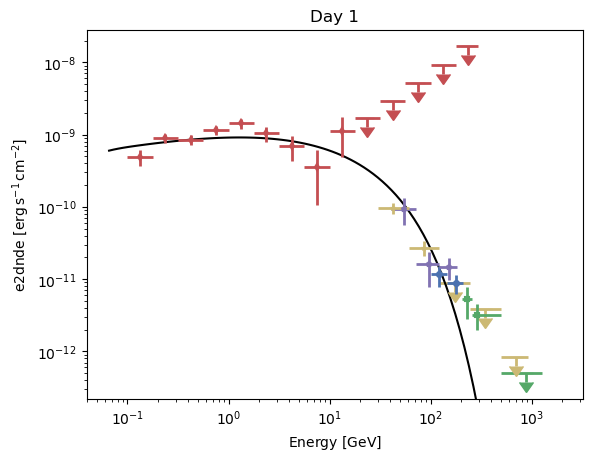

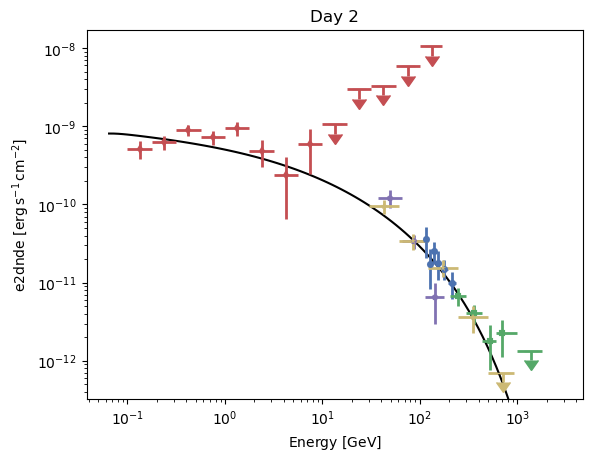

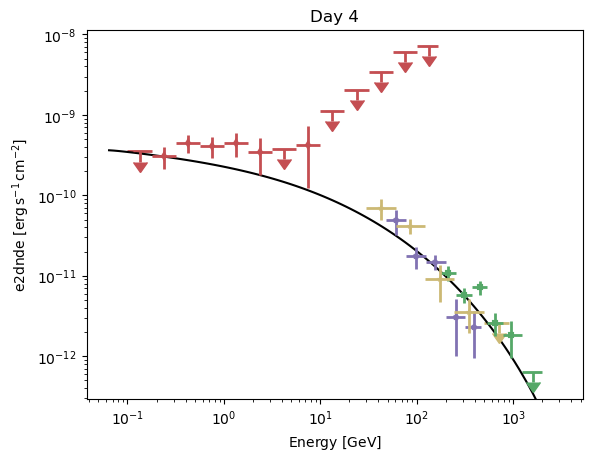

In [370]:
for day,data,spec_model in zip([1,2,4],daily_data,[spec_model_day1,spec_model_day2,spec_model_day4]):

    fig=naima.plot_data(data, e_unit=u.GeV)
    ax = fig.axes[0]
    ax.set_title(f"Day {day}")


    ax.xaxis.units = u.GeV
    ax.yaxis.units = u.Unit("erg s-1 cm-2")
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    spec_model.plot(sed_type="e2dnde",energy_bounds=[xmin*u.GeV,xmax*u.GeV],color="k",
                        label=r"Best-fit (IC)")
    ax.set_ylim((ymin, ymax))

